# Load libraries

In [58]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('darkgrid')

# Load dataset

This is a huge dataset, so to avoid running out of memory, we could only load the dataset partially

In [2]:
# Skip date information
df1 = pd.read_csv('/home/eduardo/projects/recommender-data/combined_data_1.txt',
                 header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])

In [3]:
# First row is the movie ID, following rows have customer id and rating given to movie 1
df1.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [4]:
df1.dtypes

Cust_Id     object
Rating     float64
dtype: object

In [5]:
df1.shape

(24058263, 2)

In [6]:
# NaN ratings correspond to row with a new movie ID (e.g. 1:)
df1.isna().sum()

Cust_Id       0
Rating     4499
dtype: int64

In [7]:
# Load remaining datasets
df2 = pd.read_csv('/home/eduardo/projects/recommender-data/combined_data_2.txt',
                 header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])
df3 = pd.read_csv('/home/eduardo/projects/recommender-data/combined_data_3.txt',
                 header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])
df4 = pd.read_csv('/home/eduardo/projects/recommender-data/combined_data_4.txt',
                 header=None, names=['Cust_Id', 'Rating'], usecols=[0,1])

print(df2.shape)
print(df3.shape)
print(df4.shape)

(26982302, 2)
(22605786, 2)
(26851926, 2)


In [8]:
# Merge the datasets
df = df1.append(df2)
df = df.append(df3)
df = df.append(df4)

/tmp/ipykernel_16302/269789183.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)
/tmp/ipykernel_16302/269789183.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df3)
/tmp/ipykernel_16302/269789183.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df4)


In [9]:
# Reset index and show shape
df.index = np.arange(0, len(df))
print(df.shape)
df.tail()

(100498277, 2)


,Cust_Id,Rating
100498272,1790158,4.0
100498273,1608708,3.0
100498274,234275,1.0
100498275,255278,4.0
100498276,453585,2.0


In [10]:
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [11]:
# Remove the other dfs from memory
del df1, df2, df3, df4

# Data visualization

In [12]:
# Look at the Rating distribution
rating_dist = df.groupby('Rating')['Rating'].agg(['count'])
rating_dist.head()

,count
Rating,
1.0,4617990
2.0,10132080
3.0,28811247
4.0,33750958
5.0,23168232


In [13]:
# Movie count - we know rows with movie ID have NaN rating
movie_count = df['Rating'].isnull().sum()

In [14]:
# Customer count - need to take rows that have movie IDs into account
cust_count = df['Cust_Id'].nunique() - df['Rating'].isnull().sum()

In [15]:
# Total Rating count - again, take rows with movie IDs into account
rating_count = df['Cust_Id'].count() - df['Rating'].isnull().sum()

In [16]:
rating_dist.iloc[0][0]/4

1154497.5

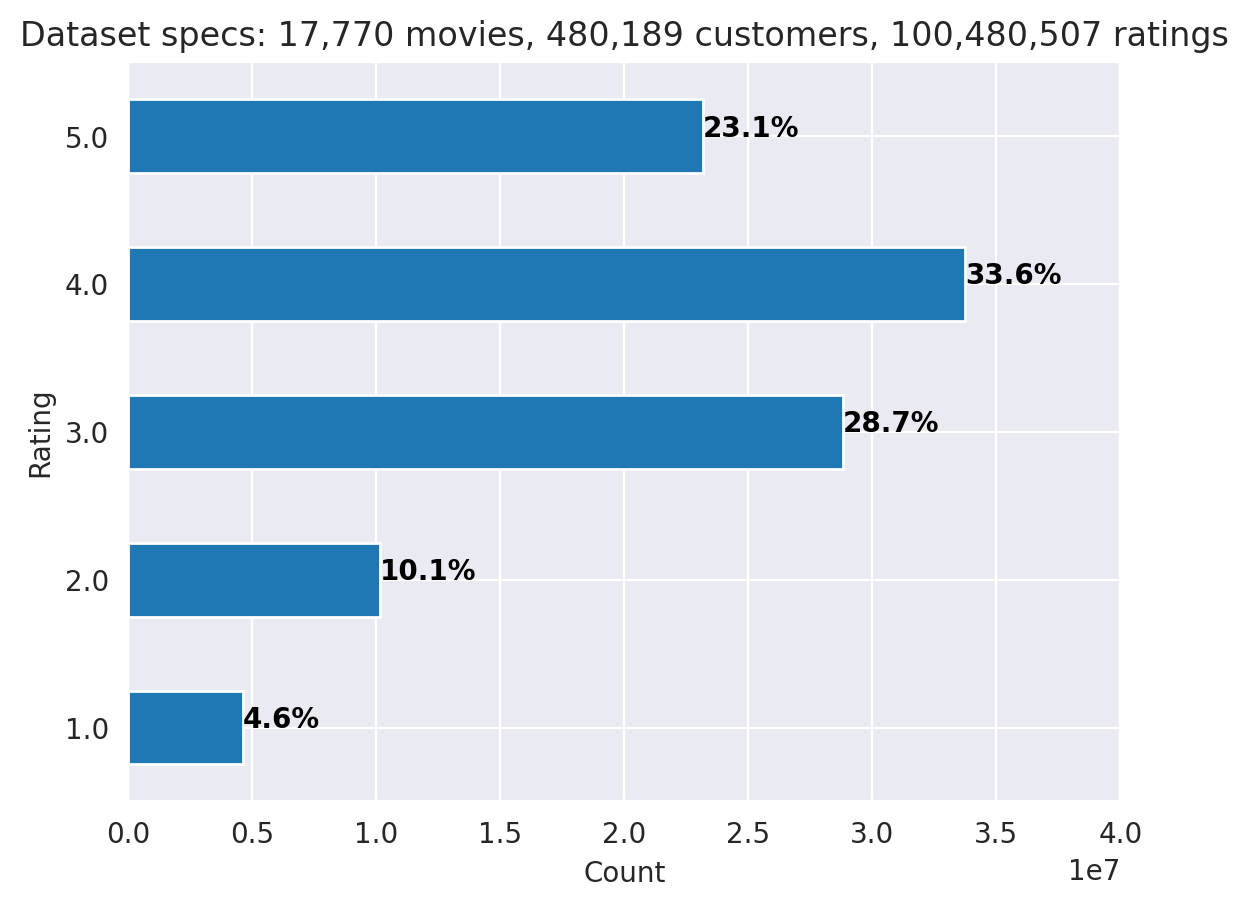

In [17]:
# Create graph object
ax = rating_dist.plot(kind='barh', legend=False)

# Add features
plt.title('Dataset specs: {:,} movies, {:,} customers, {:,} ratings'.format(movie_count, cust_count, rating_count))
plt.xlim(right=4e7)
plt.xlabel('Count')

# Add percentages to each bar
for i in range (1, 6):
    ax.text(x=rating_dist.iloc[i-1], 
            y=i-1, 
            s='{:.1f}%'.format(rating_dist.iloc[i-1][0]*100 / rating_dist.sum()[0]),
            color='black', 
            weight='bold')

plt.show()

In [18]:
# Not a normal distribution, we can see there are more ratings over 3.0

# Data cleaning

Let's create a new column using the Movie IDs. These are currently showing as a Cust_Id with missing rating, so we can easily select these rows using pandas filters.

In [18]:
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [19]:
# Create Movie_Id column using the value under Cust_Id with empty Rating
df['Movie_Id'] = df[df['Rating'].isna()]['Cust_Id'].str.replace(':', '')
df.head()

,Cust_Id,Rating,Movie_Id
0,1:,NaN,1
1,1488844,3.0,NaN
2,822109,5.0,NaN
3,885013,4.0,NaN
4,30878,4.0,NaN


In [20]:
# Fill all NaN Movie_Id using ffill - propagate last valid obsv
df['Movie_Id'].fillna(method='ffill', inplace=True)
df.head()

,Cust_Id,Rating,Movie_Id
0,1:,NaN,1
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1


In [21]:
# Drop rows with missing ratings - these correspond to Movie_Id and we have this as a new feat
df.dropna(subset='Rating', inplace=True)

In [22]:
# Check the results
print(df.head())

   Cust_Id  Rating Movie_Id
1  1488844     3.0        1
2   822109     5.0        1
3   885013     4.0        1
4    30878     4.0        1
5   823519     3.0        1


# Data Slicing

To make the dataset more manageable and also improve the quality of the recommendations, we can filter out some entries:
- Remove movies with very few reviews (since they are not popular, the rating may be less reliable)

- Remove customers with very few reviews (since there are not many reviews, it may be hard to match them with other customers as well)

Text(0.5, 0, 'Ratings per Movie')

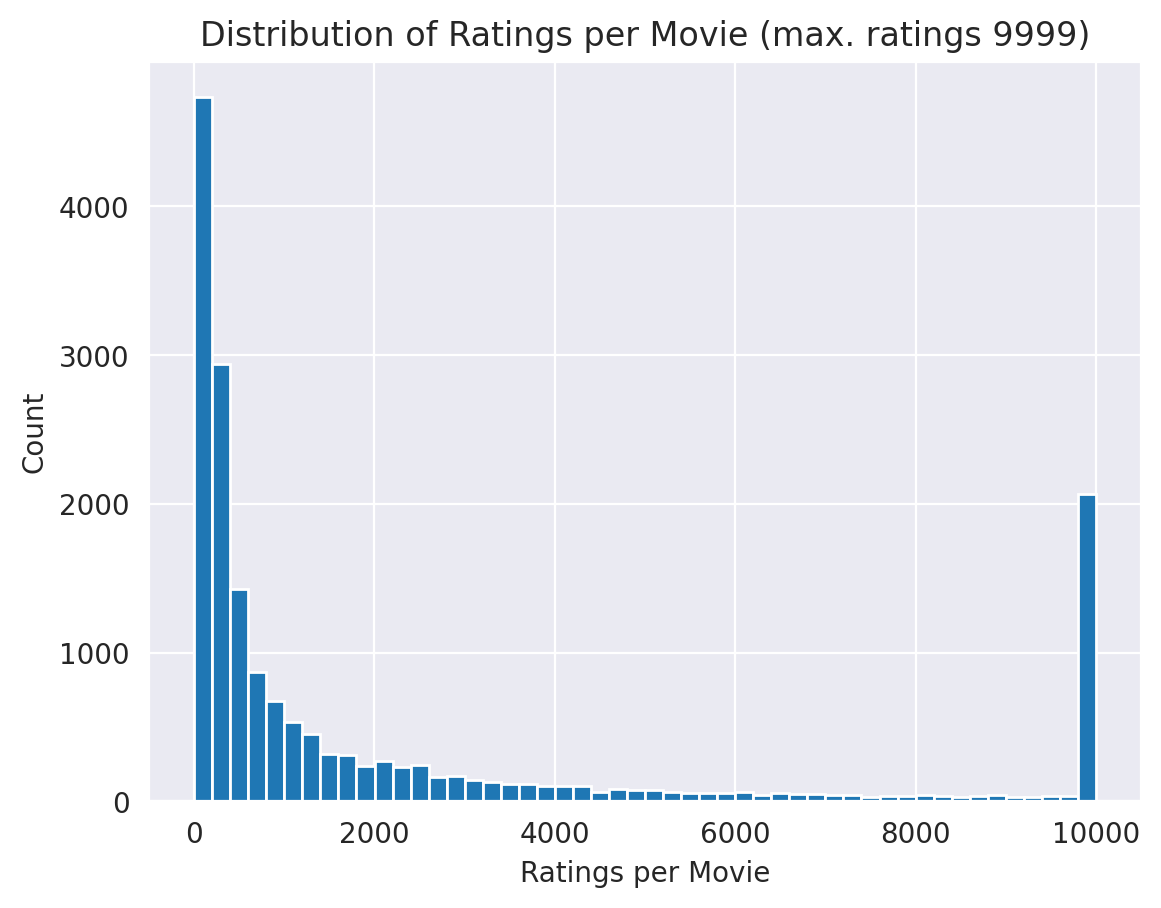

In [42]:
# Get data on number of movie ratings
data = df.groupby('Movie_Id')['Rating'].count().clip(upper=9999)

# Create a histogram to have an idea of ratings per movie
ax = data.hist(bins=50) 

ax.set_title('Distribution of Ratings per Movie (max. ratings 9999)')
ax.set_ylabel('Count')
ax.set_xlabel('Ratings per Movie')

In [43]:
len(data)

17770

In [44]:
del data

In [45]:
# Filter out movies with few ratings
# Min number of ratings per movie
min_mov_ratings = 10000

# create mask with movies that have more than min_mov_ratings
filter_movies = (df['Movie_Id'].value_counts() > min_mov_ratings)

# save index of movies with more than min_mov_ratings to a list
filter_movies = filter_movies[filter_movies].index.tolist()
len(filter_movies)

2042

We have reduced the number of movies from 17770 to 2042

In [46]:
cust_data = df.groupby('Cust_Id').count()

In [47]:
len(cust_data)

480189

In [48]:
del cust_data

In [49]:
# Filter out customers with few ratings
# Min number of ratings per customer
min_cust_ratings = 200

# Create user mask
filter_cust = (df['Cust_Id'].value_counts() > min_cust_ratings)

# Set index to a list
filter_cust = filter_cust[filter_cust].index.tolist()

In [50]:
len(filter_cust)

150245

We have reduced the number of unique users from 480189 to 150245

In [51]:
# Now combine both filters to yield a filtered dataset
df_filtered = df[(df['Movie_Id'].isin(filter_movies)) & (df['Cust_Id'].isin(filter_cust))]

In [52]:
# Remove filters from memory 
del filter_movies, filter_cust, min_mov_ratings, min_cust_ratings

In [53]:
# Compare the shapes of raw and filtered dfs
print('Shape of raw user ratings dataframe: {}'.format(df.shape))
print('Shape of filtered user ratings dataframe: {}'.format(df_filtered.shape))

Shape of raw user ratings dataframe: (100480507, 3)
Shape of filtered user ratings dataframe: (60546559, 3)


In [54]:
df_filtered.head()

,Cust_Id,Rating,Movie_Id
5106,824097,2.0,8
5109,785314,1.0,8
5110,243963,3.0,8
5112,1447783,4.0,8
5116,1912665,1.0,8
